# Using FNO Architectures to solve Inverse Problems

### Intro to Inverse Problems
***What is an inverse problem?***\
An inverse problem is a problem in which one seeks to determine the causes or inputs that gave rise to observed or measured outputs. In other words, given some observed or measured data, the inverse problem involves determining the unknown inputs or causes that produced the observed outputs.


***What is an ill-posed problem?*** \
In mathematics and science, an ill-posed problem is a problem that does not satisfy one or more of the three conditions of well-posedness: 
* existence - a solution must exist
* uniqueness - every solution must be unique
* stability of the solution - a small error in the input data or parameters should not lead to a large error in the solution.

***What is an ill-posed inverse problem?***\
An ill-posed inverse problem is a type of inverse problem that is also ill-posed. In other words, the problem of inferring the unknown inputs or causes that gave rise to observed or measured outputs does not satisfy one or more of the conditions of well-posedness, such as existence, uniqueness, and stability of the solution



In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tabulate import tabulate

torch.manual_seed(0)
np.random.seed(0)

### Testing OS and Conda is correctly configured

In [3]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())


True
True


In [20]:
dtype = torch.float
device = torch.device("mps")

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

# Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 2989.42822265625
199 1984.134521484375
299 1318.100830078125
399 876.7781982421875
499 584.3113403320312
599 390.4630126953125
699 261.95904541015625
799 176.75814819335938
899 120.25811767578125
999 82.78327941894531
1099 57.922401428222656
1199 41.426185607910156
1299 30.47764778137207
1399 23.20935821533203
1499 18.382991790771484
1599 15.17722225189209
1699 13.047297477722168
1799 11.631707191467285
1899 10.69057846069336
1999 10.064638137817383
Result: y = -0.012183338403701782 + 0.8242813348770142 x + 0.0021018297411501408 x^2 + -0.08871332556009293 x^3


# Implementing the FNO 

### 3D Implementation to the Navier Stokes

In [61]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
batch_size = 10
learning_rate = 0.001

epochs = 20
step_size = 50
gamma = 0.5

modes = 5
width = 64

weight_decay=1e-4

In [50]:
################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv3d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv3d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic

        self.p = nn.Linear(13, self.width)# input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)
        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = self.q(x)
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        return x


    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

In [9]:
raw_navier_data = scipy.io.loadmat('./datasets/NavierStokes_V1e-5_N1200_T20.mat')

In [70]:
################################################################
# configs
################################################################

PATH = './datasets/NavierStokes_V1e-5_N1200_T20.mat'

ntrain = 1000
ntest = 200

modes = 8
width = 20

batch_size = 10
learning_rate = 0.001
epochs = 10
iterations = epochs*(ntrain//batch_size)

path = 'ns_fourier_3d_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

runtime = np.zeros(2, )
t1 = default_timer()

sub = 1
S = 64 // sub
T_in = 10
T = 10 # T=40 for V1e-3; T=20 for V1e-4; T=10 for V1e-5;

In [55]:
reader = MatReader(PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

In [56]:
reader = MatReader(PATH)
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

In [57]:
print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

torch.Size([1000, 64, 64, 10])
torch.Size([200, 64, 64, 10])


In [58]:
a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [59]:
t2 = default_timer()
print('preprocessing finished, time used:', t2-t1)

preprocessing finished, time used: 12.229813040999943


In [72]:
# FNO RESULTS
############################################################################
test_num = 10 
model = FNO3d(modes, modes, modes, width).to(device)
print(count_params(model))
out = train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)

6560681
0 262.17223487499996 0.8085853219032287 0.9029650163650512
1 270.1122075000003 0.5684630889892578 0.8829256391525269
2 277.07724354200036 0.4609022469520569 0.8658654022216797
3 280.9868006249999 0.4118389720916748 0.8411669754981994
4 282.01234866600043 0.3858358795642853 0.847520956993103
5 283.3661964160001 0.3655553662776947 0.8496846270561218
6 288.47305895800037 0.3518146705627441 0.8386145329475403
7 293.55912833299953 0.3405229687690735 0.8379120230674744
8 298.49542683300024 0.33000686478614805 0.8326016068458557
9 299.9284085829995 0.3216732544898987 0.8416186475753784
TOTAL TIME: ---2836.18


In [73]:
K = torch.unsqueeze(test_loader.dataset[10][0], 0).to(device)

In [74]:
fno_model = out.get("model")


In [76]:
fno_model.eval()
predicted =fno_model(K).detach().cpu().numpy()

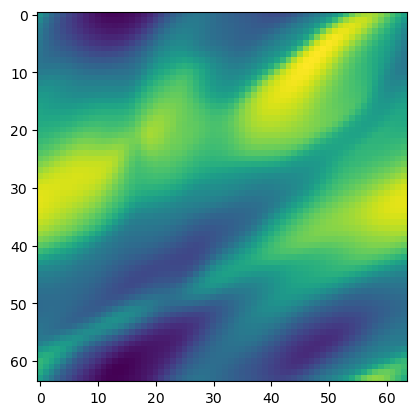

In [78]:
## Testing on unseen data.
plt.imshow(predicted[0,:,:,0,0])

## Implementation of 2D FNO to an Inverse PDE problem - using simple and fast data

### Model Metrics
We generated a set of basic image metrics which include RMSE (root-mean-square error), PSNR (peak signal-to-noise ratio) and SSIM (structural similiarity index). These metrics provide a complete overview of our reconstruction results:

 $RMSE = \sqrt{MSE} =  \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{\text{predicted} - \text{actual} }{\sigma_i}\Big)^2}}$ 
 
 
 ${PSNR} = 10\log_{10} \frac{{MAX}^2_I}{MSE}$

$ SSIM = \frac{(2\mu_x\mu_y + C_1) + (2 \sigma _{xy} + C_2)}{(\mu_x^2 + \mu_y^2+C_1) (\sigma_x^2 + \sigma_y^2+C_2)} $

These are standard image quaity and image reconstruction metrics. 

In [28]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).to(device)
        model.eval()

        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", round(model_rms,5), round(std_rms,5), sep="---")
    print("PSNR: ", round(model_psnr,5), round(std_psnr,5), sep="---")
    print("SSIM: ", round(model_ssim,5), round(std_ssim,5), sep="---")
    #print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    # average values
    'model_rms': [round(model_rms,5),round(std_rms,5)],
    'model_psnr': [round(model_psnr,5),round(std_psnr,5)],
    'model_ssim': [round(model_ssim,5),round(std_ssim,5)]
    }
    return output 

### Architectures and Training Algorithm

In [29]:
# Multi-Layer Perceptron
###################################

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
       
        self.fc0 = nn.Linear(64, 400)
        self.fc1 = nn.Linear(400, 256)

    def forward(self, x):       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.sigmoid(x)
        return x

In [30]:
# Convoluational Neural Network
###################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
       
        self.fc0 = nn.Linear(64, 256)

        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)
        #self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=5//2),
    def forward(self, x):
       
        x = self.fc0(x)
        x = x.reshape(x.shape[0],1,16,16)

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)        
        x = F.sigmoid(x)
        return x

In [31]:
#   DEFINING THE TOP 2D FOURIER LAYER
#####################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [32]:
# FNO Architecture
####################################### MODELS ###############################
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 16 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        #print('x grid input shape', x.shape, 'grid input shape', grid.shape)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [52]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", round(total_time,2), sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": round(total_time,2),
    "model": model
    }
    return output 

### Loading Raw Data

The data is generated by a 3 step process:
* Random elliptical 16 by 16 images are created
* These images are mapped into a circlular domain. (This is our solution space)
* The forward problem is solved using FEM and only the boundary values are kept. (This is our measurement space) 


Our task is to reconstruct the solution space from our set of boundary values that defines our measurement space.

In [63]:
raw_data = scipy.io.loadmat('./datasets/complete_data')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

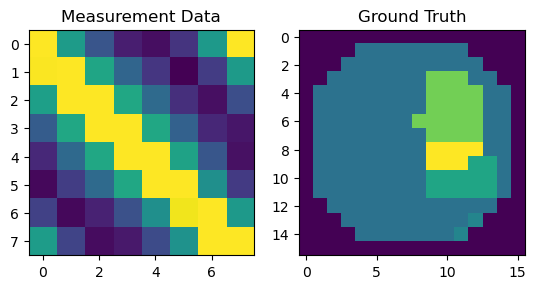

In [64]:
test_num = 423

f, axarr = plt.subplots(1,2)
axarr[0].title.set_text('Measurement Data')
axarr[0].imshow(np.reshape(mes[test_num],(8,8)))
axarr[1].title.set_text('Ground Truth')
axarr[1].imshow(np.reshape(sol[test_num],(16,16)))

# Investigating Each Architectures

### FNO : Data Loading, Training and Results

<img src= https://zongyi-li.github.io/neural-operator/img/fourier_full_arch5.png width="800">


In [46]:
# DATA LOADING
############################## DATA LOADING ########################################

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))

# dimensions of solution space
y_dim1 = 16
y_dim2 = 16

# dimensions of measurement space
x_dim2 = 8     # no of detectors
x_dim1 = int(mes.shape[1]/x_dim2)

def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_test = y_test.reshape(y_test.shape[0],y_dim1,y_dim2,1)
y_train = y_train.reshape(y_train.shape[0],y_dim1,y_dim2,1)

X_test = X_test.reshape(X_test.shape[0], x_dim1,x_dim2,1)
X_train = X_train.reshape(X_train.shape[0], x_dim1,x_dim2,1)

train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print(X_train.shape, y_train.shape)

fno_loader = test_loader

torch.Size([8000, 8, 8, 1]) torch.Size([8000, 16, 16, 1])


1664132
0 20.802166499999885 0.166266284160316 0.12317899981141091
1 20.934031957999878 0.1184460022971034 0.11360908767580986
2 20.970168707999846 0.11077890707552433 0.10508058217167854
3 20.998950582999896 0.10681659756600857 0.10606191730499268
4 20.975969707999866 0.1040009619668126 0.10104730954766274
5 20.999074125000107 0.1011705130264163 0.10258634898066521
6 21.025019832999988 0.10008476480841637 0.09723516488075257
7 21.019025332999945 0.09835758396983146 0.09762000569701194
8 21.030823832999886 0.09484455678611994 0.09570192033052445
9 21.042363209000086 0.09432793553173542 0.09196248397231102
10 21.04716329200005 0.09253247360885143 0.10370087659358979
11 21.075450332999935 0.09007255049794913 0.0919679833650589
12 21.052504208000073 0.08957727231085301 0.10656499114632606
13 21.048402125000166 0.08774116262048483 0.0911774516403675
14 21.611397665999903 0.08607982760667801 0.08696564346551895
15 21.634127457999966 0.08516174650937319 0.08375703400373459
16 21.455529542000

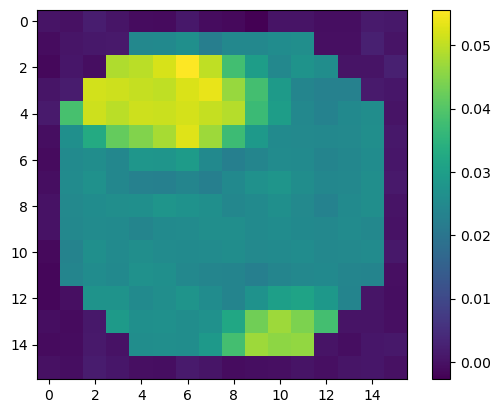

In [47]:
# FNO RESULTS
############################################################################

model = FNO2d(modes, modes, width).to(device)
print(count_params(model))
out = train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)
fno_out = out

fno_model = out.get("model")
fno_metrics = model_metrics(fno_model,test_loader,ntrain)

# TEST PREDICTIONS
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).to(device)
fno_model.eval()
predicted = np.reshape(fno_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

### MLP : Data Loading, Training and Results

<img src= https://images.deepai.org/glossary-terms/49157de013394ab7a36022759a55b6aa/multipercep.jpg width="600">


In [38]:
# DATA LOADING
############################## DATA LOADING ########################################
X, y = convert_data(mes, sol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print('training: measurement', X_train.shape, 'solution', y_train.shape)
print('test: measurement', X_test.shape, 'solution', y_test.shape)

mlp_loader = test_loader

training: measurement torch.Size([8000, 64]) solution torch.Size([8000, 256])
test: measurement torch.Size([2000, 64]) solution torch.Size([2000, 256])


128656
0 0.4798551670000961 0.9220539232492447 0.776522399187088
1 0.459261541999922 0.6734874342978001 0.40173179852962493
2 0.500265833000185 0.246770461589098 0.16889045596122743
3 0.4574748750001163 0.17425971883535385 0.21876934051513672
4 0.4540780419999919 0.15938313560187817 0.14659036427736283
5 0.4529078750001645 0.14810657048225404 0.13681151160597801
6 0.4557677089999288 0.14355759401619433 0.1498059219121933
7 0.45361962499987385 0.1415105291083455 0.14412218230962753
8 0.4588632080001389 0.13940945745259523 0.1303683333992958
9 0.4557944159998897 0.13588417135179043 0.166428927898407
10 0.45749320799995985 0.13629769019782542 0.13093154209852217
11 0.4573293339999509 0.13417245548963547 0.12908452826738356
12 0.4572679580001022 0.13363302107900382 0.13543557435274123
13 0.45864991700000246 0.13280865371972322 0.1317081513106823
14 0.4501194170002236 0.1316836483106017 0.1256203238964081
15 0.4537993330000063 0.13059920666366814 0.1263338427245617
16 0.4511811659999694 0.1

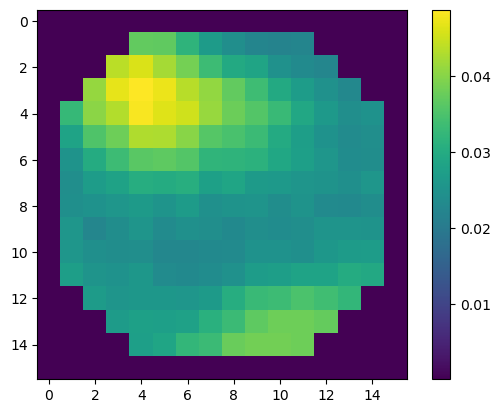

In [42]:
model = MLP().to(device)
print(count_params(model))
out = train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)
mlp_out = out

mlp_model = out.get("model")
mlp_metrics = model_metrics(mlp_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).to(device)
mlp_model.eval()
predicted = np.reshape(mlp_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

### CNN DATA AND RESULTS

<img src= https://miro.medium.com/max/1400/1*hYN6b13CKaTN1jnafkq5KQ.jpeg width="800">

In [43]:
# we are solving the inverse problem, so going from measurements, to solutions

X_dim = X_train.shape[1]
y_dim = y_train.shape[1]

X_train = X_train.reshape(ntrain,1,X_dim)
X_test = X_test.reshape(ntest,1,X_dim)

y_train = y_train.reshape(ntrain,1,16,16)
y_test = y_test.reshape(ntest,1,16,16)

train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('training data: measurements', X_train.shape, 'solution', y_train.shape)
print('training data: measurements', X_test.shape, 'solution', y_test.shape)

cnn_loader = test_loader

training data: measurements torch.Size([8000, 1, 64]) solution torch.Size([8000, 1, 16, 16])
training data: measurements torch.Size([2000, 1, 64]) solution torch.Size([2000, 1, 16, 16])


20097
0 1.00891108299993 0.7017168063223362 0.28333117651939393
1 0.9910559999998441 0.24696073658764361 0.2040865597128868
2 0.8969239169998673 0.2029537862688303 0.22266729438304902
3 0.8913648749999084 0.18633519534766674 0.17360471910238265
4 0.8964897500000006 0.1758810895383358 0.17321325516700745
5 0.8884460410001793 0.16657539996504783 0.15826143485307692
6 0.8925722919998407 0.15918996015191078 0.15099721068143845
7 0.9001174999998511 0.15531235589087009 0.17443570101261138
8 0.8935297909999917 0.15112347450852395 0.1498851798772812
9 0.9267147499999737 0.14861998514831065 0.14892020654678345
10 0.8898990419997972 0.1450805028155446 0.13777428638935088
11 0.8921539580001081 0.14224711690098046 0.14672803342342378
12 0.8913249580000411 0.14153608464449643 0.14093208003044128
13 0.894343458999856 0.14011348708719015 0.13374685820937157
14 0.895135707999998 0.13760531213879584 0.14588632464408874
15 0.8954539999999724 0.13895522399246693 0.13429374593496324
16 0.8925419170000168 

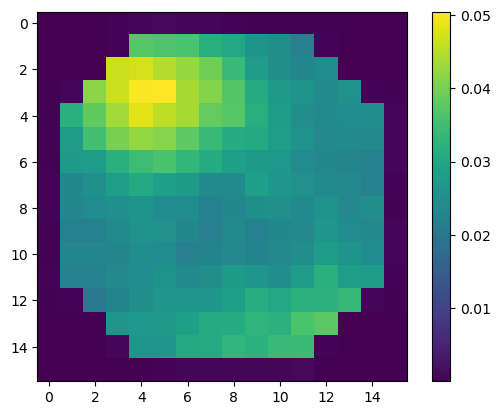

In [44]:
# SIGMA - TEST NETWORK
############################################################################

model = CNN().to(device)
print(count_params(model))
out = train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma)
cnn_out = out

cnn_model = out.get("model")
cnn_metrics = model_metrics(cnn_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).to(device)
cnn_model.eval()
predicted = np.reshape(cnn_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

### Direct Comparison Between Models

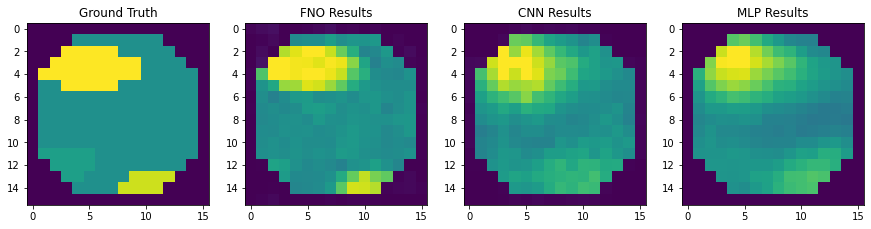

In [26]:
test_num = 423

### GROUND TRUTH, FNO, MLP, CNN


f, axarr = plt.subplots(1,4, figsize=(15, 15))

truth_out = test_loader.dataset[test_num][1]
axarr[0].title.set_text('Ground Truth')
axarr[0].imshow(np.reshape(truth_out.numpy(),(16,16)), vmin=0, vmax=0.05)

K = torch.unsqueeze(fno_loader.dataset[test_num][0], 0).to(device)
predicted = np.reshape(fno_model(K).detach().cpu().numpy(),(16,16))
axarr[1].title.set_text('FNO Results')
axarr[1].imshow(predicted, vmin=0, vmax=0.05)

K = torch.unsqueeze(cnn_loader.dataset[test_num][0], 0).to(device)
predicted = np.reshape(cnn_model(K).detach().cpu().numpy(),(16,16))
axarr[2].title.set_text('CNN Results')
axarr[2].imshow(predicted, vmin=0, vmax=0.05)


K = torch.unsqueeze(mlp_loader.dataset[test_num][0], 0).to(device)
predicted = np.reshape(mlp_model(K).detach().cpu().numpy(),(16,16))
axarr[3].title.set_text('MLP Results')
axarr[3].imshow(predicted, vmin=0, vmax=0.05)

In [30]:
table = [['Architecture', 'Time (s)', 'RMSE (mean,std)', 'PSNR (mean,std)', 'SSIM (mean,std)', 'Training Time (s)'],
         ['FNO', fno_out.get("training_time"), fno_metrics.get('model_rms'), fno_metrics.get('model_psnr'), fno_metrics.get('model_ssim')], 
         ['CNN', cnn_out.get("training_time"), cnn_metrics.get('model_rms'), cnn_metrics.get('model_psnr'), cnn_metrics.get('model_ssim')], 
         ['MLP', mlp_out.get("training_time"), mlp_metrics.get('model_rms'), mlp_metrics.get('model_psnr'), mlp_metrics.get('model_ssim')]]


print(tabulate(table, headers='firstrow'))

Architecture      Time (s)  RMSE (mean,std)     PSNR (mean,std)      SSIM (mean,std)
--------------  ----------  ------------------  -------------------  ------------------
FNO                 247.33  [0.00222, 0.00104]  [27.94514, 2.91786]  [0.92098, 0.02336]
CNN                  54.5   [0.00361, 0.00146]  [23.09314, 2.25803]  [0.80454, 0.04876]
MLP                  36.41  [0.0034, 0.00144]   [23.67901, 2.37488]  [0.82297, 0.04106]


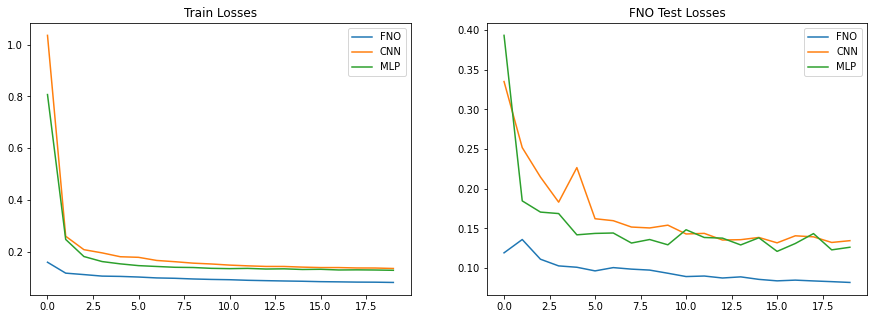

In [59]:
f, axarr = plt.subplots(1,2, figsize=(15, 5))

#FNO LOSSES
axarr[0].title.set_text('Train Losses')
axarr[0].plot(fno_out.get("train_losses"), label='FNO')
axarr[0].plot(cnn_out.get("train_losses"), label='CNN')
axarr[0].plot(mlp_out.get("train_losses"), label='MLP')
axarr[0].legend()
#axarr[0,0].set_ylim([0.08, 0.16])


axarr[1].title.set_text('Test Losses')
axarr[1].plot(fno_out.get("test_losses"), label='FNO')
axarr[1].plot(cnn_out.get("test_losses"), label='CNN')
axarr[1].plot(mlp_out.get("test_losses"), label='MLP')
axarr[1].legend()
#axarr[0,1].set_ylim([0.08, 0.16])
